# Taller 3

**Autor:** Juan Pablo Gaviria

## Clasificación de documentos con Naive Bayes

In [1]:
import pandas as pd
import multiprocessing as mp
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn import svm

### Lectura de la información

In [2]:
# Se lee el data set original
originalData = pd.read_csv('/home/jgaviria/Workspace/DataScience/datasets/metadata.csv')
originalData

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636.0,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967.0,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972.0,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871.0,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888.0,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128487,a11jyui1,NaN,Elsevier; PMC,Impact of BSE on the biotechnology industry — ...,10.1016/s0958-2118(04)00238-1,PMC7148827,NaN,els-covid,This feature briefly looks at filtration techn...,2004-10-31,"Atkinson, Simon",Membrane Technology,NaN,NaN,NaN,NaN,NaN,https://www.sciencedirect.com/science/article/...,109580667.0
128488,9bma9y0q,44959e4505dcc59575f4989de8abf3fcc7e48415,Medline; PMC,Evolving Gene Targets and Technology in Influe...,10.1007/s40291-013-0040-9,PMC7100497,23686537.0,no-cc,Influenza viruses cause recurring epidemic out...,2013-05-18,"Malanoski, Anthony P.; Lin, Baochuan",Mol Diagn Ther,NaN,NaN,NaN,document_parses/pdf_json/44959e4505dcc59575f49...,document_parses/pmc_json/PMC7100497.xml.json,NaN,17361009.0
128489,50xhia4r,8922380f61b6fe160ab0550a674816f1852a843d,Medline; PMC; WHO,How to train health personnel to protect thems...,10.3352/jeehp.2020.17.10,PMC7162995,32150796.0,cc-by,NaN,2020-03-07,"Huh, Sun",J Educ Eval Health Prof,NaN,#6263,NaN,document_parses/pdf_json/8922380f61b6fe160ab05...,document_parses/pmc_json/PMC7162995.xml.json,NaN,212650605.0
128490,97h1fz34,ea20a6b97f98ce4bdddfa6408da5ddf3dd06835e,Medline; PMC,Epidemic spreading in complex networks,10.1007/s11467-008-0027-x,PMC7111544,32288753.0,no-cc,The study of epidemic spreading in complex net...,2008-07-08,"Zhou, Jie; Liu, Zong-hua",Front Phys China,NaN,NaN,NaN,document_parses/pdf_json/ea20a6b97f98ce4bdddfa...,NaN,NaN,121665618.0


In [3]:
# Se lee la informacion clasificada (salida de la deteccion de topicos)
topicos = pd.read_pickle('docTopicDetection.pkl')
topicos

,docId,topico
0,ug7v899j,0
1,02tnwd4m,3
2,ejv2xln0,4
3,2b73a28n,4
4,9785vg6d,3
...,...,...
128486,jvl63652,3
128487,a11jyui1,3
128488,9bma9y0q,2
128490,97h1fz34,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8cd6194ad0>]],
      dtype=object)

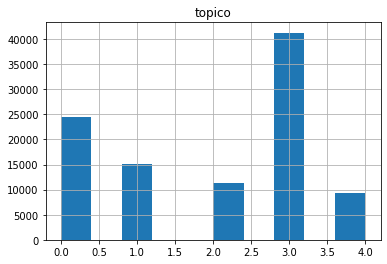

In [4]:
# Histograma con la distribucion de los topicos
topicos.hist()

### Preparacion de la informacion

In [5]:
# Se crea nuevo dataframe unicamente con el id y el texto a evaluar
texto = pd.DataFrame({'docId':originalData.cord_uid, 'texto':originalData.title+" "+originalData.abstract})
texto

,docId,texto
0,ug7v899j,Clinical features of culture-proven Mycoplasma...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...
2,ejv2xln0,Surfactant protein-D and pulmonary host defens...
3,2b73a28n,Role of endothelin-1 in lung disease Endotheli...
4,9785vg6d,Gene expression in epithelial cells in respons...
...,...,...
128487,a11jyui1,Impact of BSE on the biotechnology industry — ...
128488,9bma9y0q,Evolving Gene Targets and Technology in Influe...
128489,50xhia4r,NaN
128490,97h1fz34,Epidemic spreading in complex networks The stu...


In [6]:
# Se agrega columna con la categoria
textoCategorizado = texto.set_index('docId').join(topicos.set_index('docId'),on='docId')
textoCategorizado

,texto,topico
docId,,
ug7v899j,Clinical features of culture-proven Mycoplasma...,0.0
02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,3.0
ejv2xln0,Surfactant protein-D and pulmonary host defens...,4.0
2b73a28n,Role of endothelin-1 in lung disease Endotheli...,4.0
9785vg6d,Gene expression in epithelial cells in respons...,3.0
...,...,...
a11jyui1,Impact of BSE on the biotechnology industry — ...,3.0
9bma9y0q,Evolving Gene Targets and Technology in Influe...,2.0
50xhia4r,NaN,NaN


In [7]:
# Se eliminan las filas nulas, no tienen ni titulo ni texto por lo que no se pueden analizar
textoCategorizado = textoCategorizado.dropna()
textoCategorizado

,texto,topico
docId,,
ug7v899j,Clinical features of culture-proven Mycoplasma...,0.0
02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,3.0
ejv2xln0,Surfactant protein-D and pulmonary host defens...,4.0
2b73a28n,Role of endothelin-1 in lung disease Endotheli...,4.0
9785vg6d,Gene expression in epithelial cells in respons...,3.0
...,...,...
jvl63652,Dual Analysis of the Murine Cytomegalovirus an...,3.0
a11jyui1,Impact of BSE on the biotechnology industry — ...,3.0
9bma9y0q,Evolving Gene Targets and Technology in Influe...,2.0


### Preparacion del texto

Se realiza limpieza del texto. Se utilizan algoritmos de nltk,
diferentes a los utilizados en la deteccion de topicos con el
fin de evaluar la precisión del modelo

In [8]:
# Funcion que limpia un documento para ser llamada de forma paralela
stopwordsEnglish = set(stopwords.words('english'))
porter = PorterStemmer()
def limpiarDoc(documento):
    # Tokenizacion
    tokens = nltk.word_tokenize(documento)
    # Eliminacion de caracteres especiales
    tokens = [re.sub(r'[^A-Za-z0-9]+',' ',w) for w in tokens]
    # Paso de tokens a minusculas
    tokens = [w.lower() for w in tokens if len(w) > 1]
    # Eliminacion de stopwords
    tokens = [w for w in tokens if w not in stopwordsEnglish]
    # Lemma
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    # Stemming
    tokens = [porter.stem(w) for w in tokens]
    tokens = ' '.join(tokens)
    return tokens




In [9]:
# Se realiza limpieza y tokenizacion de forma paralela
t0 = time.time()
pool = mp.Pool()
textoCategorizado['tokens'] = pool.map(limpiarDoc, textoCategorizado['texto'])
pool.close()
print('Tiempo tomado: '+str(time.time()-t0))


Tiempo tomado: 98.41768956184387


In [10]:
textoCategorizado

,texto,topico,tokens
docId,,,
ug7v899j,Clinical features of culture-proven Mycoplasma...,0.0,clinic featur culture proven mycoplasma pneumo...
02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,3.0,nitric oxid pro inflammatori mediat lung disea...
ejv2xln0,Surfactant protein-D and pulmonary host defens...,4.0,surfact protein d pulmonari host defens surfac...
2b73a28n,Role of endothelin-1 in lung disease Endotheli...,4.0,role endothelin 1 lung diseas endothelin 1 et ...
9785vg6d,Gene expression in epithelial cells in respons...,3.0,gene express epitheli cell respons pneumoviru ...
...,...,...,...
jvl63652,Dual Analysis of the Murine Cytomegalovirus an...,3.0,dual analysi murin cytomegaloviru host cell tr...
a11jyui1,Impact of BSE on the biotechnology industry — ...,3.0,impact bse biotechnolog industri detect risk a...
9bma9y0q,Evolving Gene Targets and Technology in Influe...,2.0,evolv gene target technolog influenza detect i...


### Preparación del modelo

In [11]:
# TF
countVector = CountVectorizer(min_df=8)
termFrecuency = countVector.fit_transform(textoCategorizado.texto)

In [12]:
# TF IDF
tfidfTrans = TfidfTransformer().fit(termFrecuency)
tfidfVector = tfidfTrans.transform(termFrecuency)

### Aplicación del modelo

In [13]:
# Se separa el conjunto de entrenamiento y el de test
x_train, x_test, y_train, y_test = train_test_split(tfidfVector, textoCategorizado.topico)

In [14]:
# Entrenamiento del modelo
model = MultinomialNB().fit(x_train, y_train)

### Evaluación del modelo

In [15]:
prediccion = model.predict(x_test)
precision = np.mean(prediccion == y_test)
print('Precision del modelo: {0:.2%}'.format(precision))

Precision del modelo: 78.59%


## Clasificación de documentos SVM

Se realiza clasificación con SVM para comparar con el modelo aplicado de Naive Bayes

In [16]:
clasificador = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clasificador.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Evaluación del modelo

In [ ]:
prediccion = clasificador.predict(x_test)
precision = np.mean(prediccion == y_test)
print('Precision del modelo: {0:.2%}'.format(precision))

### Ejecución del modelo

In [28]:
def categorizarBayes(documento):
    tokens = limpiarDoc(documento)
    tf = countVector.transform([tokens])
    tfidf = tfidfTrans.transform(tf)
    return model.predict(tfidf)

def categorizarSVM(documento):
    tokens = limpiarDoc(documento)
    tf = countVector.transform([tokens])
    tfidf = tfidfTrans.transform(tf)
    return clasificador.predict(tfidf)

In [30]:
documentos = 'Breakthrough: Chloroquine phosphate has shown apparent efficacy in treatment of COVID-19 associated pneumonia in clinical studies The coronavirus disease 2019 (COVID-19) virus is spreading rapidly, and scientists are endeavoring to discover drugs for its efficacious treatment in China. Chloroquine phosphate, an old drug for treatment of malaria, is shown to have apparent efficacy and acceptable safety against COVID-19 associated pneumonia in multicenter clinical trials conducted in China. The drug is recommended to be included in the next version of the Guidelines for the Prevention, Diagnosis, and Treatment of Pneumonia Caused by COVID-19 issued by the National Health Commission of the People s Republic of China for treatment of COVID-19 infection in larger populations in the future'
# Prediccion Bayes
t0 = time.time()
topicoBayes = categorizarBayes(documentos)
print('Bayes Topico: '+str(topicoBayes)+' Tiempo tomado: '+str(time.time()-t0))

# Prediccion SVM
t0 = time.time()
topicoSVM = categorizarSVM(documentos)
print('SVM Topico: '+str(topicoSVM)+' Tiempo tomado: '+str(time.time()-t0))

Bayes Topico: [3.] Tiempo tomado: 0.004874229431152344
SVM Topico: [3.] Tiempo tomado: 0.029401063919067383
